<a href="https://colab.research.google.com/github/Imakaul/First-Repository-/blob/main/Melanoma_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# git comment

In [73]:
from keras_preprocessing.image import ImageDataGenerator

In [74]:
import os 
import matplotlib.pyplot as plt

In [75]:
unlabeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True)

In [76]:
unlabeled_datagen = unlabeled_data_gen.flow_from_directory(directory="/content/drive/MyDrive/MelanomaDetection/MelanomaDetection",target_size=(32,32),
                                                           classes=["unlabeled"],batch_size=256)

Found 7018 images belonging to 1 classes.


In [77]:
from keras.models import Sequential
from keras.layers import Input,Conv2D,LeakyReLU,Flatten,Dropout,Dense,Reshape,Conv2DTranspose,BatchNormalization

In [78]:
import tensorflow as tf

In [79]:
def discriminator():

  dis = Sequential(name="Discriminator")
  dis.add(Conv2D(filters=64,kernel_size=4,strides=2,padding="same",input_shape=(32,32,3),use_bias=False))
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=256,kernel_size=4,strides=2,padding="same",use_bias= False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Flatten())
  dis.add(Dropout(0.4))

  dis.add(Dense(units=1,activation="sigmoid"))

  return dis

In [80]:
def generator():

  noise_shape = 100
  gen = Sequential(name="Generator")

  gen.add(Input(shape=(noise_shape,)))
  gen.add(Dense(units=4*4*100))
  gen.add(Reshape((4,4,100)))

  gen.add(Conv2DTranspose(filters=256,kernel_size=4,strides=1,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))


  gen.add(Conv2DTranspose(filters=3,kernel_size=4,strides=2,padding="same",activation="tanh",use_bias=False))

  return gen
  


In [81]:
D= discriminator()

In [82]:
D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        3072      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         131072    
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)         524288    
                                                     

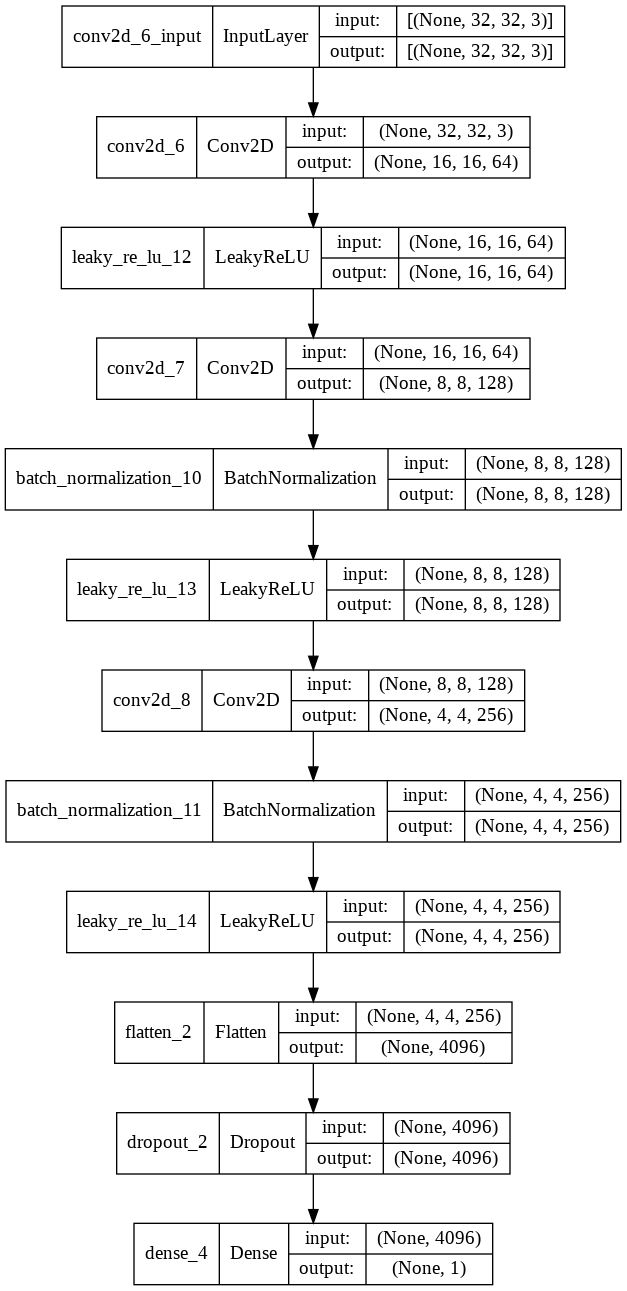

In [83]:
tf.keras.utils.plot_model(model=D,show_shapes=True)

In [84]:
G= generator()

In [85]:
G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1600)              161600    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 4, 4, 256)        409600    
 ranspose)                                                       
                                                                 
 batch_normalization_12 (Bat  (None, 4, 4, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 8, 8, 128)        52

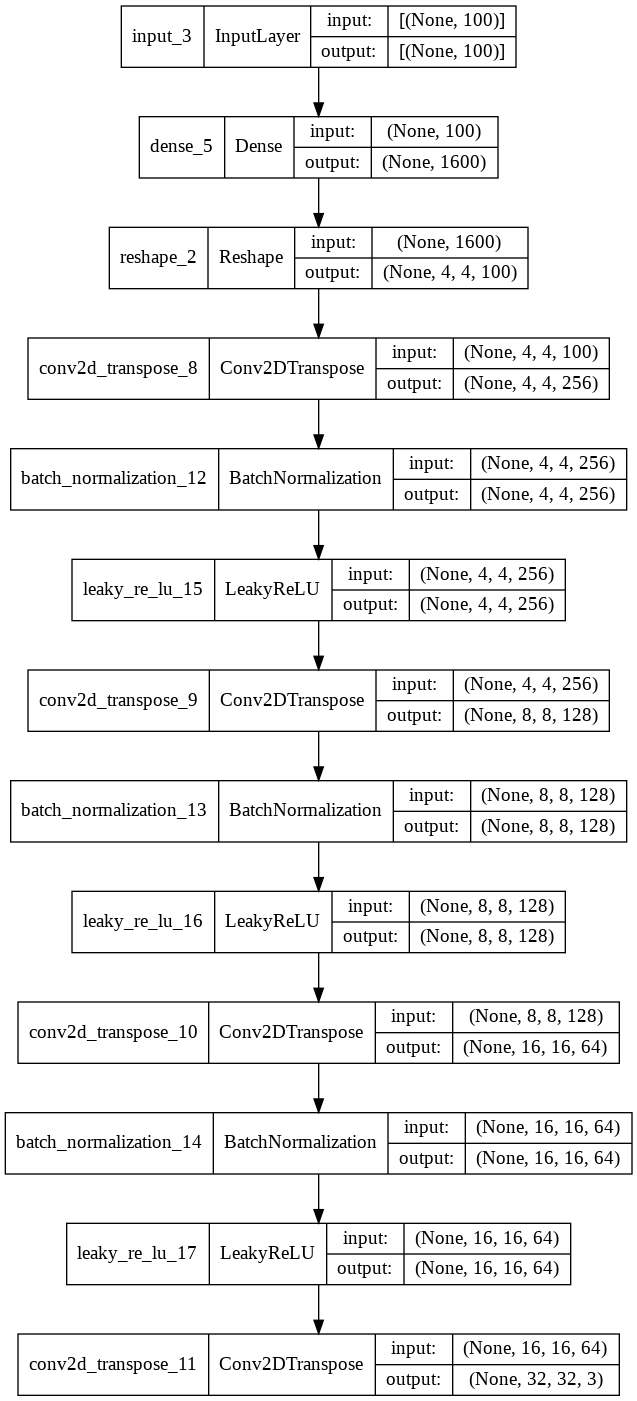

In [86]:
tf.keras.utils.plot_model(model=G,show_shapes=True)

In [87]:
random_noise = tf.random.normal(shape=(1,100))

In [88]:
generated_image = G(random_noise,training=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


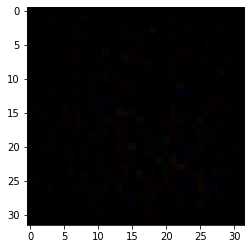

In [89]:
plt.imshow(generated_image[0,:,:,:])

In [90]:
posterior = D(generated_image)

In [91]:
print(posterior)

tf.Tensor([[0.5001376]], shape=(1, 1), dtype=float32)


In [92]:
GAN_epochs = 50
noise_shape= 100
batch_size = 256

In [93]:
import keras
from IPython import display
import numpy as np 

In [94]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [95]:
def D_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(real_imgs_preds)) + tf.ones_like(real_imgs_preds)
  fake_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(fake_imgs_preds)) + tf.zeros_like(fake_imgs_preds)

  real_imgs_bce_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_bce_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_bce_loss + fake_imgs_bce_loss

  return total_loss

In [96]:
def G_loss(fake_imgs_preds):

  fake_imgs_labels = tf.ones_like(fake_imgs_preds)

  return bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

In [97]:
D_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0008,beta_1=0.3)
G_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0004,beta_1=0.1)

In [98]:
GAN_checkpoint_dir = "/content/drive/MyDrive/GAN_training_checkpoints"
GAN_checkpoint_prefix = os.path.join(GAN_checkpoint_dir,"ckpt")
GAN_checkpoint = tf.train.Checkpoint(optimizer=[D_optimizer,G_optimizer],model=[D,G])

In [99]:
@tf.function
def training_step(real_imgs_mini_batch):

  G.trainable = False
  noise = tf.random.normal(shape=(batch_size,noise_shape))
  generated_imgs_mini_batch = G(noise,training=False)

  D.trainable = True

  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

    real_imgs_preds = D(real_imgs_mini_batch,training=True)
    fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

    disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
    D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

    D.trainable = False
    G.trainable = True

    noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_imgs_mini_batch = G(noise,training=True)

    fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

    gen_loss = G_loss(fake_imgs_preds)

    gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
    G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

In [100]:
constant_noise = tf.random.normal(shape=(16,noise_shape))

In [101]:
def generate_and_save_images(generator_model,epoch,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.savefig("Images_at_Epoch_{:04d}.png".format(epoch))
  plt.show()

In [102]:
real_imgs_path = "/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/unlabeled"

In [103]:
def train_gan(real_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for image_batch in real_imgs_datagen:

      print("Training GAN at Time Step {} of Epoch {}".format(time_step,epoch+1))
      training_step(real_imgs_mini_batch=image_batch[0])

      if time_step > len(os.listdir(real_imgs_path))//batch_size:
        break

      time_step = time_step + 1

    generate_and_save_images(generator_model=G,epoch=epoch+1,test_input=constant_noise)

    if (epoch + 1) % 5 == 0:
      GAN_checkpoint.save(file_prefix=GAN_checkpoint_prefix)

  generate_and_save_images(generator_model=G,epoch=total_epochs,test_input=constant_noise)

Training GAN at Time Step 1 of Epoch 1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Training GAN at Time Step 2 of Epoch 1
Training GAN at Time Step 3 of Epoch 1
Training GAN at Time Step 4 of Epoch 1
Training GAN at Time Step 5 of Epoch 1
Training GAN at Time Step 6 of Epoch 1
Training GAN at Time Step 7 of Epoch 1
Training GAN at Time Step 8 of Epoch 1
Training GAN at Time Step 9 of Epoch 1
Training GAN at Time Step 10 of Epoch 1
Training GAN at Time Step 11 of Epoch 1
Training GAN at Time Step 12 of Epoch 1
Training GAN at Time Step 13 of Epoch 1
Training GAN at Time Step 14 of Epoch 1
Training GAN at Time Step 15 of Epoch 1
Training GAN at Time Step 16 of Epoch 1
Training GAN at Time Step 17 of Epoch 1
Training GAN at Time Step 18 of Epoch 1
Training GAN at Time Step 19 of Epoch 1
Training GAN at Time Step 20 of Epoch 1
Training GAN at Time Step 21 of Epoch 1
Training GAN at Time Step 22 of Epoch 1
Training GAN at Time Step 23 of Epoch 1
Training GAN at Time Step 24 of Epoch 1
Training GAN at Time Step 25 of Epoch 1
Training GAN at Time Step 26 of Epoch 1
Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

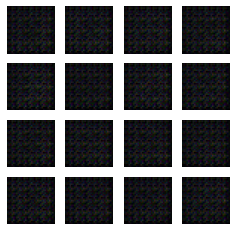

Training GAN at Time Step 1 of Epoch 2
Training GAN at Time Step 2 of Epoch 2
Training GAN at Time Step 3 of Epoch 2
Training GAN at Time Step 4 of Epoch 2
Training GAN at Time Step 5 of Epoch 2
Training GAN at Time Step 6 of Epoch 2
Training GAN at Time Step 7 of Epoch 2
Training GAN at Time Step 8 of Epoch 2
Training GAN at Time Step 9 of Epoch 2
Training GAN at Time Step 10 of Epoch 2
Training GAN at Time Step 11 of Epoch 2
Training GAN at Time Step 12 of Epoch 2
Training GAN at Time Step 13 of Epoch 2
Training GAN at Time Step 14 of Epoch 2
Training GAN at Time Step 15 of Epoch 2
Training GAN at Time Step 16 of Epoch 2
Training GAN at Time Step 17 of Epoch 2
Training GAN at Time Step 18 of Epoch 2
Training GAN at Time Step 19 of Epoch 2
Training GAN at Time Step 20 of Epoch 2
Training GAN at Time Step 21 of Epoch 2
Training GAN at Time Step 22 of Epoch 2
Training GAN at Time Step 23 of Epoch 2
Training GAN at Time Step 24 of Epoch 2
Training GAN at Time Step 25 of Epoch 2
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

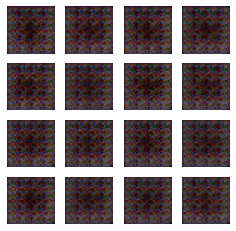

Training GAN at Time Step 1 of Epoch 3
Training GAN at Time Step 2 of Epoch 3
Training GAN at Time Step 3 of Epoch 3
Training GAN at Time Step 4 of Epoch 3
Training GAN at Time Step 5 of Epoch 3
Training GAN at Time Step 6 of Epoch 3
Training GAN at Time Step 7 of Epoch 3
Training GAN at Time Step 8 of Epoch 3
Training GAN at Time Step 9 of Epoch 3
Training GAN at Time Step 10 of Epoch 3
Training GAN at Time Step 11 of Epoch 3
Training GAN at Time Step 12 of Epoch 3
Training GAN at Time Step 13 of Epoch 3
Training GAN at Time Step 14 of Epoch 3
Training GAN at Time Step 15 of Epoch 3
Training GAN at Time Step 16 of Epoch 3
Training GAN at Time Step 17 of Epoch 3
Training GAN at Time Step 18 of Epoch 3
Training GAN at Time Step 19 of Epoch 3
Training GAN at Time Step 20 of Epoch 3
Training GAN at Time Step 21 of Epoch 3
Training GAN at Time Step 22 of Epoch 3
Training GAN at Time Step 23 of Epoch 3
Training GAN at Time Step 24 of Epoch 3
Training GAN at Time Step 25 of Epoch 3
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

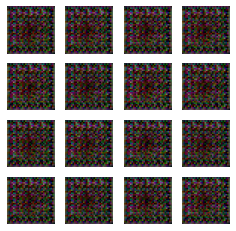

Training GAN at Time Step 1 of Epoch 4
Training GAN at Time Step 2 of Epoch 4
Training GAN at Time Step 3 of Epoch 4
Training GAN at Time Step 4 of Epoch 4
Training GAN at Time Step 5 of Epoch 4
Training GAN at Time Step 6 of Epoch 4
Training GAN at Time Step 7 of Epoch 4
Training GAN at Time Step 8 of Epoch 4
Training GAN at Time Step 9 of Epoch 4
Training GAN at Time Step 10 of Epoch 4
Training GAN at Time Step 11 of Epoch 4
Training GAN at Time Step 12 of Epoch 4
Training GAN at Time Step 13 of Epoch 4
Training GAN at Time Step 14 of Epoch 4
Training GAN at Time Step 15 of Epoch 4
Training GAN at Time Step 16 of Epoch 4
Training GAN at Time Step 17 of Epoch 4
Training GAN at Time Step 18 of Epoch 4
Training GAN at Time Step 19 of Epoch 4
Training GAN at Time Step 20 of Epoch 4
Training GAN at Time Step 21 of Epoch 4
Training GAN at Time Step 22 of Epoch 4
Training GAN at Time Step 23 of Epoch 4
Training GAN at Time Step 24 of Epoch 4
Training GAN at Time Step 25 of Epoch 4
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

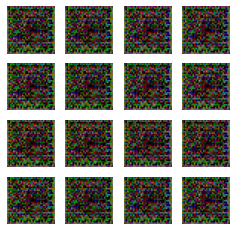

Training GAN at Time Step 1 of Epoch 5
Training GAN at Time Step 2 of Epoch 5
Training GAN at Time Step 3 of Epoch 5
Training GAN at Time Step 4 of Epoch 5
Training GAN at Time Step 5 of Epoch 5
Training GAN at Time Step 6 of Epoch 5
Training GAN at Time Step 7 of Epoch 5
Training GAN at Time Step 8 of Epoch 5
Training GAN at Time Step 9 of Epoch 5
Training GAN at Time Step 10 of Epoch 5
Training GAN at Time Step 11 of Epoch 5
Training GAN at Time Step 12 of Epoch 5
Training GAN at Time Step 13 of Epoch 5
Training GAN at Time Step 14 of Epoch 5
Training GAN at Time Step 15 of Epoch 5
Training GAN at Time Step 16 of Epoch 5
Training GAN at Time Step 17 of Epoch 5
Training GAN at Time Step 18 of Epoch 5
Training GAN at Time Step 19 of Epoch 5
Training GAN at Time Step 20 of Epoch 5
Training GAN at Time Step 21 of Epoch 5
Training GAN at Time Step 22 of Epoch 5
Training GAN at Time Step 23 of Epoch 5
Training GAN at Time Step 24 of Epoch 5
Training GAN at Time Step 25 of Epoch 5
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

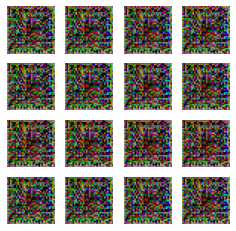

Training GAN at Time Step 1 of Epoch 6
Training GAN at Time Step 2 of Epoch 6
Training GAN at Time Step 3 of Epoch 6
Training GAN at Time Step 4 of Epoch 6
Training GAN at Time Step 5 of Epoch 6
Training GAN at Time Step 6 of Epoch 6
Training GAN at Time Step 7 of Epoch 6
Training GAN at Time Step 8 of Epoch 6
Training GAN at Time Step 9 of Epoch 6
Training GAN at Time Step 10 of Epoch 6
Training GAN at Time Step 11 of Epoch 6
Training GAN at Time Step 12 of Epoch 6
Training GAN at Time Step 13 of Epoch 6
Training GAN at Time Step 14 of Epoch 6
Training GAN at Time Step 15 of Epoch 6
Training GAN at Time Step 16 of Epoch 6
Training GAN at Time Step 17 of Epoch 6
Training GAN at Time Step 18 of Epoch 6
Training GAN at Time Step 19 of Epoch 6
Training GAN at Time Step 20 of Epoch 6
Training GAN at Time Step 21 of Epoch 6
Training GAN at Time Step 22 of Epoch 6
Training GAN at Time Step 23 of Epoch 6
Training GAN at Time Step 24 of Epoch 6
Training GAN at Time Step 25 of Epoch 6
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

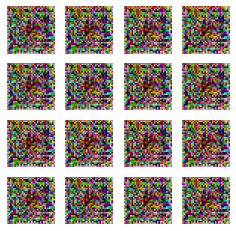

Training GAN at Time Step 1 of Epoch 7
Training GAN at Time Step 2 of Epoch 7
Training GAN at Time Step 3 of Epoch 7
Training GAN at Time Step 4 of Epoch 7
Training GAN at Time Step 5 of Epoch 7
Training GAN at Time Step 6 of Epoch 7
Training GAN at Time Step 7 of Epoch 7
Training GAN at Time Step 8 of Epoch 7
Training GAN at Time Step 9 of Epoch 7
Training GAN at Time Step 10 of Epoch 7
Training GAN at Time Step 11 of Epoch 7
Training GAN at Time Step 12 of Epoch 7
Training GAN at Time Step 13 of Epoch 7
Training GAN at Time Step 14 of Epoch 7
Training GAN at Time Step 15 of Epoch 7
Training GAN at Time Step 16 of Epoch 7
Training GAN at Time Step 17 of Epoch 7
Training GAN at Time Step 18 of Epoch 7
Training GAN at Time Step 19 of Epoch 7
Training GAN at Time Step 20 of Epoch 7
Training GAN at Time Step 21 of Epoch 7
Training GAN at Time Step 22 of Epoch 7
Training GAN at Time Step 23 of Epoch 7
Training GAN at Time Step 24 of Epoch 7
Training GAN at Time Step 25 of Epoch 7
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

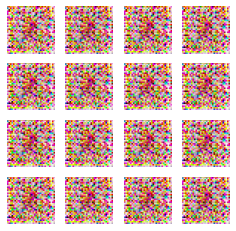

Training GAN at Time Step 1 of Epoch 8
Training GAN at Time Step 2 of Epoch 8
Training GAN at Time Step 3 of Epoch 8
Training GAN at Time Step 4 of Epoch 8
Training GAN at Time Step 5 of Epoch 8
Training GAN at Time Step 6 of Epoch 8
Training GAN at Time Step 7 of Epoch 8
Training GAN at Time Step 8 of Epoch 8
Training GAN at Time Step 9 of Epoch 8
Training GAN at Time Step 10 of Epoch 8
Training GAN at Time Step 11 of Epoch 8
Training GAN at Time Step 12 of Epoch 8
Training GAN at Time Step 13 of Epoch 8
Training GAN at Time Step 14 of Epoch 8
Training GAN at Time Step 15 of Epoch 8
Training GAN at Time Step 16 of Epoch 8
Training GAN at Time Step 17 of Epoch 8
Training GAN at Time Step 18 of Epoch 8
Training GAN at Time Step 19 of Epoch 8
Training GAN at Time Step 20 of Epoch 8
Training GAN at Time Step 21 of Epoch 8
Training GAN at Time Step 22 of Epoch 8
Training GAN at Time Step 23 of Epoch 8
Training GAN at Time Step 24 of Epoch 8
Training GAN at Time Step 25 of Epoch 8
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

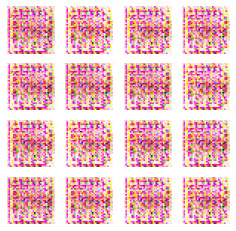

Training GAN at Time Step 1 of Epoch 9
Training GAN at Time Step 2 of Epoch 9
Training GAN at Time Step 3 of Epoch 9
Training GAN at Time Step 4 of Epoch 9
Training GAN at Time Step 5 of Epoch 9
Training GAN at Time Step 6 of Epoch 9
Training GAN at Time Step 7 of Epoch 9
Training GAN at Time Step 8 of Epoch 9
Training GAN at Time Step 9 of Epoch 9
Training GAN at Time Step 10 of Epoch 9
Training GAN at Time Step 11 of Epoch 9
Training GAN at Time Step 12 of Epoch 9
Training GAN at Time Step 13 of Epoch 9
Training GAN at Time Step 14 of Epoch 9
Training GAN at Time Step 15 of Epoch 9
Training GAN at Time Step 16 of Epoch 9
Training GAN at Time Step 17 of Epoch 9
Training GAN at Time Step 18 of Epoch 9
Training GAN at Time Step 19 of Epoch 9
Training GAN at Time Step 20 of Epoch 9
Training GAN at Time Step 21 of Epoch 9
Training GAN at Time Step 22 of Epoch 9
Training GAN at Time Step 23 of Epoch 9
Training GAN at Time Step 24 of Epoch 9
Training GAN at Time Step 25 of Epoch 9
Training 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

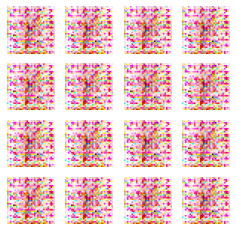

Training GAN at Time Step 1 of Epoch 10
Training GAN at Time Step 2 of Epoch 10
Training GAN at Time Step 3 of Epoch 10
Training GAN at Time Step 4 of Epoch 10
Training GAN at Time Step 5 of Epoch 10
Training GAN at Time Step 6 of Epoch 10
Training GAN at Time Step 7 of Epoch 10
Training GAN at Time Step 8 of Epoch 10
Training GAN at Time Step 9 of Epoch 10
Training GAN at Time Step 10 of Epoch 10
Training GAN at Time Step 11 of Epoch 10
Training GAN at Time Step 12 of Epoch 10
Training GAN at Time Step 13 of Epoch 10
Training GAN at Time Step 14 of Epoch 10
Training GAN at Time Step 15 of Epoch 10
Training GAN at Time Step 16 of Epoch 10
Training GAN at Time Step 17 of Epoch 10
Training GAN at Time Step 18 of Epoch 10
Training GAN at Time Step 19 of Epoch 10
Training GAN at Time Step 20 of Epoch 10
Training GAN at Time Step 21 of Epoch 10
Training GAN at Time Step 22 of Epoch 10
Training GAN at Time Step 23 of Epoch 10
Training GAN at Time Step 24 of Epoch 10
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

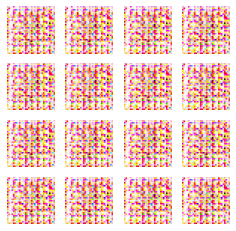

Training GAN at Time Step 1 of Epoch 11
Training GAN at Time Step 2 of Epoch 11
Training GAN at Time Step 3 of Epoch 11
Training GAN at Time Step 4 of Epoch 11
Training GAN at Time Step 5 of Epoch 11
Training GAN at Time Step 6 of Epoch 11
Training GAN at Time Step 7 of Epoch 11
Training GAN at Time Step 8 of Epoch 11
Training GAN at Time Step 9 of Epoch 11
Training GAN at Time Step 10 of Epoch 11
Training GAN at Time Step 11 of Epoch 11
Training GAN at Time Step 12 of Epoch 11
Training GAN at Time Step 13 of Epoch 11
Training GAN at Time Step 14 of Epoch 11
Training GAN at Time Step 15 of Epoch 11
Training GAN at Time Step 16 of Epoch 11
Training GAN at Time Step 17 of Epoch 11
Training GAN at Time Step 18 of Epoch 11
Training GAN at Time Step 19 of Epoch 11
Training GAN at Time Step 20 of Epoch 11
Training GAN at Time Step 21 of Epoch 11
Training GAN at Time Step 22 of Epoch 11
Training GAN at Time Step 23 of Epoch 11
Training GAN at Time Step 24 of Epoch 11
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

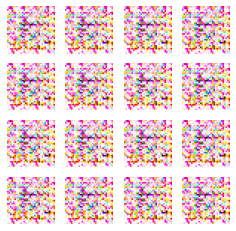

Training GAN at Time Step 1 of Epoch 12
Training GAN at Time Step 2 of Epoch 12
Training GAN at Time Step 3 of Epoch 12
Training GAN at Time Step 4 of Epoch 12
Training GAN at Time Step 5 of Epoch 12
Training GAN at Time Step 6 of Epoch 12
Training GAN at Time Step 7 of Epoch 12
Training GAN at Time Step 8 of Epoch 12
Training GAN at Time Step 9 of Epoch 12
Training GAN at Time Step 10 of Epoch 12
Training GAN at Time Step 11 of Epoch 12
Training GAN at Time Step 12 of Epoch 12
Training GAN at Time Step 13 of Epoch 12
Training GAN at Time Step 14 of Epoch 12
Training GAN at Time Step 15 of Epoch 12
Training GAN at Time Step 16 of Epoch 12
Training GAN at Time Step 17 of Epoch 12
Training GAN at Time Step 18 of Epoch 12
Training GAN at Time Step 19 of Epoch 12
Training GAN at Time Step 20 of Epoch 12
Training GAN at Time Step 21 of Epoch 12
Training GAN at Time Step 22 of Epoch 12
Training GAN at Time Step 23 of Epoch 12
Training GAN at Time Step 24 of Epoch 12
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

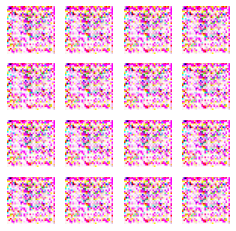

Training GAN at Time Step 1 of Epoch 13
Training GAN at Time Step 2 of Epoch 13
Training GAN at Time Step 3 of Epoch 13
Training GAN at Time Step 4 of Epoch 13
Training GAN at Time Step 5 of Epoch 13
Training GAN at Time Step 6 of Epoch 13
Training GAN at Time Step 7 of Epoch 13
Training GAN at Time Step 8 of Epoch 13
Training GAN at Time Step 9 of Epoch 13
Training GAN at Time Step 10 of Epoch 13
Training GAN at Time Step 11 of Epoch 13
Training GAN at Time Step 12 of Epoch 13
Training GAN at Time Step 13 of Epoch 13
Training GAN at Time Step 14 of Epoch 13
Training GAN at Time Step 15 of Epoch 13
Training GAN at Time Step 16 of Epoch 13
Training GAN at Time Step 17 of Epoch 13
Training GAN at Time Step 18 of Epoch 13
Training GAN at Time Step 19 of Epoch 13
Training GAN at Time Step 20 of Epoch 13
Training GAN at Time Step 21 of Epoch 13
Training GAN at Time Step 22 of Epoch 13
Training GAN at Time Step 23 of Epoch 13
Training GAN at Time Step 24 of Epoch 13
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

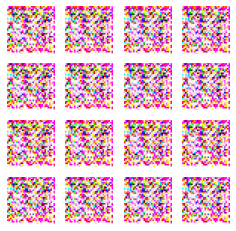

Training GAN at Time Step 1 of Epoch 14
Training GAN at Time Step 2 of Epoch 14
Training GAN at Time Step 3 of Epoch 14
Training GAN at Time Step 4 of Epoch 14
Training GAN at Time Step 5 of Epoch 14
Training GAN at Time Step 6 of Epoch 14
Training GAN at Time Step 7 of Epoch 14
Training GAN at Time Step 8 of Epoch 14
Training GAN at Time Step 9 of Epoch 14
Training GAN at Time Step 10 of Epoch 14
Training GAN at Time Step 11 of Epoch 14
Training GAN at Time Step 12 of Epoch 14
Training GAN at Time Step 13 of Epoch 14
Training GAN at Time Step 14 of Epoch 14
Training GAN at Time Step 15 of Epoch 14
Training GAN at Time Step 16 of Epoch 14
Training GAN at Time Step 17 of Epoch 14
Training GAN at Time Step 18 of Epoch 14
Training GAN at Time Step 19 of Epoch 14
Training GAN at Time Step 20 of Epoch 14
Training GAN at Time Step 21 of Epoch 14
Training GAN at Time Step 22 of Epoch 14
Training GAN at Time Step 23 of Epoch 14
Training GAN at Time Step 24 of Epoch 14
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

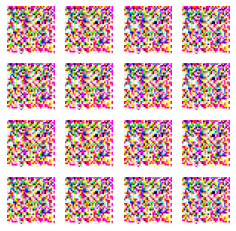

Training GAN at Time Step 1 of Epoch 15
Training GAN at Time Step 2 of Epoch 15
Training GAN at Time Step 3 of Epoch 15
Training GAN at Time Step 4 of Epoch 15
Training GAN at Time Step 5 of Epoch 15
Training GAN at Time Step 6 of Epoch 15
Training GAN at Time Step 7 of Epoch 15
Training GAN at Time Step 8 of Epoch 15
Training GAN at Time Step 9 of Epoch 15
Training GAN at Time Step 10 of Epoch 15
Training GAN at Time Step 11 of Epoch 15
Training GAN at Time Step 12 of Epoch 15
Training GAN at Time Step 13 of Epoch 15
Training GAN at Time Step 14 of Epoch 15
Training GAN at Time Step 15 of Epoch 15
Training GAN at Time Step 16 of Epoch 15
Training GAN at Time Step 17 of Epoch 15
Training GAN at Time Step 18 of Epoch 15
Training GAN at Time Step 19 of Epoch 15
Training GAN at Time Step 20 of Epoch 15
Training GAN at Time Step 21 of Epoch 15
Training GAN at Time Step 22 of Epoch 15
Training GAN at Time Step 23 of Epoch 15
Training GAN at Time Step 24 of Epoch 15
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

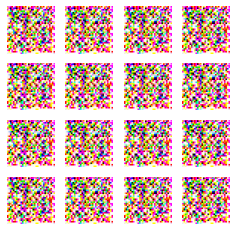

Training GAN at Time Step 1 of Epoch 16
Training GAN at Time Step 2 of Epoch 16
Training GAN at Time Step 3 of Epoch 16
Training GAN at Time Step 4 of Epoch 16
Training GAN at Time Step 5 of Epoch 16
Training GAN at Time Step 6 of Epoch 16
Training GAN at Time Step 7 of Epoch 16
Training GAN at Time Step 8 of Epoch 16
Training GAN at Time Step 9 of Epoch 16
Training GAN at Time Step 10 of Epoch 16
Training GAN at Time Step 11 of Epoch 16
Training GAN at Time Step 12 of Epoch 16
Training GAN at Time Step 13 of Epoch 16
Training GAN at Time Step 14 of Epoch 16
Training GAN at Time Step 15 of Epoch 16
Training GAN at Time Step 16 of Epoch 16
Training GAN at Time Step 17 of Epoch 16
Training GAN at Time Step 18 of Epoch 16
Training GAN at Time Step 19 of Epoch 16
Training GAN at Time Step 20 of Epoch 16
Training GAN at Time Step 21 of Epoch 16
Training GAN at Time Step 22 of Epoch 16
Training GAN at Time Step 23 of Epoch 16
Training GAN at Time Step 24 of Epoch 16
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

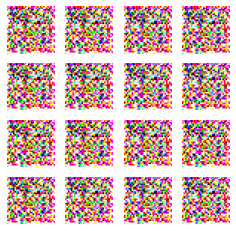

Training GAN at Time Step 1 of Epoch 17
Training GAN at Time Step 2 of Epoch 17
Training GAN at Time Step 3 of Epoch 17
Training GAN at Time Step 4 of Epoch 17
Training GAN at Time Step 5 of Epoch 17
Training GAN at Time Step 6 of Epoch 17
Training GAN at Time Step 7 of Epoch 17
Training GAN at Time Step 8 of Epoch 17
Training GAN at Time Step 9 of Epoch 17
Training GAN at Time Step 10 of Epoch 17
Training GAN at Time Step 11 of Epoch 17
Training GAN at Time Step 12 of Epoch 17
Training GAN at Time Step 13 of Epoch 17
Training GAN at Time Step 14 of Epoch 17
Training GAN at Time Step 15 of Epoch 17
Training GAN at Time Step 16 of Epoch 17
Training GAN at Time Step 17 of Epoch 17
Training GAN at Time Step 18 of Epoch 17
Training GAN at Time Step 19 of Epoch 17
Training GAN at Time Step 20 of Epoch 17
Training GAN at Time Step 21 of Epoch 17
Training GAN at Time Step 22 of Epoch 17
Training GAN at Time Step 23 of Epoch 17
Training GAN at Time Step 24 of Epoch 17
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

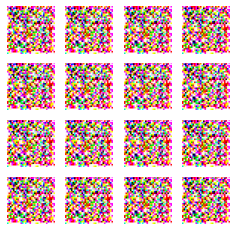

Training GAN at Time Step 1 of Epoch 18
Training GAN at Time Step 2 of Epoch 18
Training GAN at Time Step 3 of Epoch 18
Training GAN at Time Step 4 of Epoch 18
Training GAN at Time Step 5 of Epoch 18
Training GAN at Time Step 6 of Epoch 18
Training GAN at Time Step 7 of Epoch 18
Training GAN at Time Step 8 of Epoch 18
Training GAN at Time Step 9 of Epoch 18
Training GAN at Time Step 10 of Epoch 18
Training GAN at Time Step 11 of Epoch 18
Training GAN at Time Step 12 of Epoch 18
Training GAN at Time Step 13 of Epoch 18
Training GAN at Time Step 14 of Epoch 18
Training GAN at Time Step 15 of Epoch 18
Training GAN at Time Step 16 of Epoch 18
Training GAN at Time Step 17 of Epoch 18
Training GAN at Time Step 18 of Epoch 18
Training GAN at Time Step 19 of Epoch 18
Training GAN at Time Step 20 of Epoch 18
Training GAN at Time Step 21 of Epoch 18
Training GAN at Time Step 22 of Epoch 18
Training GAN at Time Step 23 of Epoch 18
Training GAN at Time Step 24 of Epoch 18
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

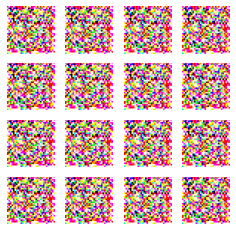

Training GAN at Time Step 1 of Epoch 19
Training GAN at Time Step 2 of Epoch 19
Training GAN at Time Step 3 of Epoch 19
Training GAN at Time Step 4 of Epoch 19
Training GAN at Time Step 5 of Epoch 19
Training GAN at Time Step 6 of Epoch 19
Training GAN at Time Step 7 of Epoch 19
Training GAN at Time Step 8 of Epoch 19
Training GAN at Time Step 9 of Epoch 19
Training GAN at Time Step 10 of Epoch 19
Training GAN at Time Step 11 of Epoch 19
Training GAN at Time Step 12 of Epoch 19
Training GAN at Time Step 13 of Epoch 19
Training GAN at Time Step 14 of Epoch 19
Training GAN at Time Step 15 of Epoch 19
Training GAN at Time Step 16 of Epoch 19
Training GAN at Time Step 17 of Epoch 19
Training GAN at Time Step 18 of Epoch 19
Training GAN at Time Step 19 of Epoch 19
Training GAN at Time Step 20 of Epoch 19
Training GAN at Time Step 21 of Epoch 19
Training GAN at Time Step 22 of Epoch 19
Training GAN at Time Step 23 of Epoch 19
Training GAN at Time Step 24 of Epoch 19
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

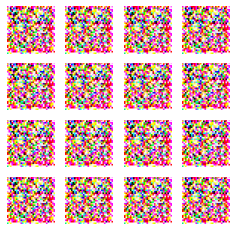

Training GAN at Time Step 1 of Epoch 20
Training GAN at Time Step 2 of Epoch 20
Training GAN at Time Step 3 of Epoch 20
Training GAN at Time Step 4 of Epoch 20
Training GAN at Time Step 5 of Epoch 20
Training GAN at Time Step 6 of Epoch 20
Training GAN at Time Step 7 of Epoch 20
Training GAN at Time Step 8 of Epoch 20
Training GAN at Time Step 9 of Epoch 20
Training GAN at Time Step 10 of Epoch 20
Training GAN at Time Step 11 of Epoch 20
Training GAN at Time Step 12 of Epoch 20
Training GAN at Time Step 13 of Epoch 20
Training GAN at Time Step 14 of Epoch 20
Training GAN at Time Step 15 of Epoch 20
Training GAN at Time Step 16 of Epoch 20
Training GAN at Time Step 17 of Epoch 20
Training GAN at Time Step 18 of Epoch 20
Training GAN at Time Step 19 of Epoch 20
Training GAN at Time Step 20 of Epoch 20
Training GAN at Time Step 21 of Epoch 20
Training GAN at Time Step 22 of Epoch 20
Training GAN at Time Step 23 of Epoch 20
Training GAN at Time Step 24 of Epoch 20
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

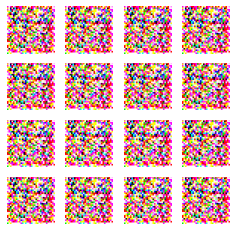

Training GAN at Time Step 1 of Epoch 21
Training GAN at Time Step 2 of Epoch 21
Training GAN at Time Step 3 of Epoch 21
Training GAN at Time Step 4 of Epoch 21
Training GAN at Time Step 5 of Epoch 21
Training GAN at Time Step 6 of Epoch 21
Training GAN at Time Step 7 of Epoch 21
Training GAN at Time Step 8 of Epoch 21
Training GAN at Time Step 9 of Epoch 21
Training GAN at Time Step 10 of Epoch 21
Training GAN at Time Step 11 of Epoch 21
Training GAN at Time Step 12 of Epoch 21
Training GAN at Time Step 13 of Epoch 21
Training GAN at Time Step 14 of Epoch 21
Training GAN at Time Step 15 of Epoch 21
Training GAN at Time Step 16 of Epoch 21
Training GAN at Time Step 17 of Epoch 21
Training GAN at Time Step 18 of Epoch 21
Training GAN at Time Step 19 of Epoch 21
Training GAN at Time Step 20 of Epoch 21
Training GAN at Time Step 21 of Epoch 21
Training GAN at Time Step 22 of Epoch 21
Training GAN at Time Step 23 of Epoch 21
Training GAN at Time Step 24 of Epoch 21
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

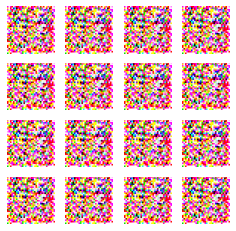

Training GAN at Time Step 1 of Epoch 22
Training GAN at Time Step 2 of Epoch 22
Training GAN at Time Step 3 of Epoch 22
Training GAN at Time Step 4 of Epoch 22
Training GAN at Time Step 5 of Epoch 22
Training GAN at Time Step 6 of Epoch 22
Training GAN at Time Step 7 of Epoch 22
Training GAN at Time Step 8 of Epoch 22
Training GAN at Time Step 9 of Epoch 22
Training GAN at Time Step 10 of Epoch 22
Training GAN at Time Step 11 of Epoch 22
Training GAN at Time Step 12 of Epoch 22
Training GAN at Time Step 13 of Epoch 22
Training GAN at Time Step 14 of Epoch 22
Training GAN at Time Step 15 of Epoch 22
Training GAN at Time Step 16 of Epoch 22
Training GAN at Time Step 17 of Epoch 22
Training GAN at Time Step 18 of Epoch 22
Training GAN at Time Step 19 of Epoch 22
Training GAN at Time Step 20 of Epoch 22
Training GAN at Time Step 21 of Epoch 22
Training GAN at Time Step 22 of Epoch 22
Training GAN at Time Step 23 of Epoch 22
Training GAN at Time Step 24 of Epoch 22
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

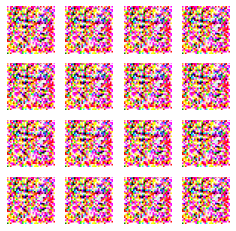

Training GAN at Time Step 1 of Epoch 23
Training GAN at Time Step 2 of Epoch 23
Training GAN at Time Step 3 of Epoch 23
Training GAN at Time Step 4 of Epoch 23
Training GAN at Time Step 5 of Epoch 23
Training GAN at Time Step 6 of Epoch 23
Training GAN at Time Step 7 of Epoch 23
Training GAN at Time Step 8 of Epoch 23
Training GAN at Time Step 9 of Epoch 23
Training GAN at Time Step 10 of Epoch 23
Training GAN at Time Step 11 of Epoch 23
Training GAN at Time Step 12 of Epoch 23
Training GAN at Time Step 13 of Epoch 23
Training GAN at Time Step 14 of Epoch 23
Training GAN at Time Step 15 of Epoch 23
Training GAN at Time Step 16 of Epoch 23
Training GAN at Time Step 17 of Epoch 23
Training GAN at Time Step 18 of Epoch 23
Training GAN at Time Step 19 of Epoch 23
Training GAN at Time Step 20 of Epoch 23
Training GAN at Time Step 21 of Epoch 23
Training GAN at Time Step 22 of Epoch 23
Training GAN at Time Step 23 of Epoch 23
Training GAN at Time Step 24 of Epoch 23
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

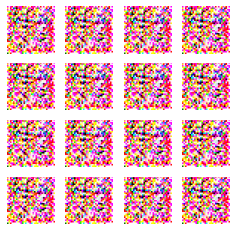

Training GAN at Time Step 1 of Epoch 24
Training GAN at Time Step 2 of Epoch 24
Training GAN at Time Step 3 of Epoch 24
Training GAN at Time Step 4 of Epoch 24
Training GAN at Time Step 5 of Epoch 24
Training GAN at Time Step 6 of Epoch 24
Training GAN at Time Step 7 of Epoch 24
Training GAN at Time Step 8 of Epoch 24
Training GAN at Time Step 9 of Epoch 24
Training GAN at Time Step 10 of Epoch 24
Training GAN at Time Step 11 of Epoch 24
Training GAN at Time Step 12 of Epoch 24
Training GAN at Time Step 13 of Epoch 24
Training GAN at Time Step 14 of Epoch 24
Training GAN at Time Step 15 of Epoch 24
Training GAN at Time Step 16 of Epoch 24
Training GAN at Time Step 17 of Epoch 24
Training GAN at Time Step 18 of Epoch 24
Training GAN at Time Step 19 of Epoch 24
Training GAN at Time Step 20 of Epoch 24
Training GAN at Time Step 21 of Epoch 24
Training GAN at Time Step 22 of Epoch 24
Training GAN at Time Step 23 of Epoch 24
Training GAN at Time Step 24 of Epoch 24
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

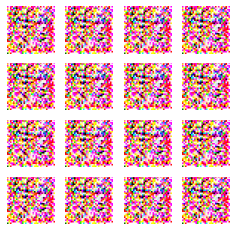

Training GAN at Time Step 1 of Epoch 25
Training GAN at Time Step 2 of Epoch 25
Training GAN at Time Step 3 of Epoch 25
Training GAN at Time Step 4 of Epoch 25
Training GAN at Time Step 5 of Epoch 25
Training GAN at Time Step 6 of Epoch 25
Training GAN at Time Step 7 of Epoch 25
Training GAN at Time Step 8 of Epoch 25
Training GAN at Time Step 9 of Epoch 25
Training GAN at Time Step 10 of Epoch 25
Training GAN at Time Step 11 of Epoch 25
Training GAN at Time Step 12 of Epoch 25
Training GAN at Time Step 13 of Epoch 25
Training GAN at Time Step 14 of Epoch 25
Training GAN at Time Step 15 of Epoch 25
Training GAN at Time Step 16 of Epoch 25
Training GAN at Time Step 17 of Epoch 25
Training GAN at Time Step 18 of Epoch 25
Training GAN at Time Step 19 of Epoch 25
Training GAN at Time Step 20 of Epoch 25
Training GAN at Time Step 21 of Epoch 25
Training GAN at Time Step 22 of Epoch 25
Training GAN at Time Step 23 of Epoch 25
Training GAN at Time Step 24 of Epoch 25
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

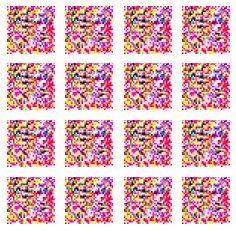

Training GAN at Time Step 1 of Epoch 26
Training GAN at Time Step 2 of Epoch 26
Training GAN at Time Step 3 of Epoch 26
Training GAN at Time Step 4 of Epoch 26
Training GAN at Time Step 5 of Epoch 26
Training GAN at Time Step 6 of Epoch 26
Training GAN at Time Step 7 of Epoch 26
Training GAN at Time Step 8 of Epoch 26
Training GAN at Time Step 9 of Epoch 26
Training GAN at Time Step 10 of Epoch 26
Training GAN at Time Step 11 of Epoch 26
Training GAN at Time Step 12 of Epoch 26
Training GAN at Time Step 13 of Epoch 26
Training GAN at Time Step 14 of Epoch 26
Training GAN at Time Step 15 of Epoch 26
Training GAN at Time Step 16 of Epoch 26
Training GAN at Time Step 17 of Epoch 26
Training GAN at Time Step 18 of Epoch 26
Training GAN at Time Step 19 of Epoch 26
Training GAN at Time Step 20 of Epoch 26
Training GAN at Time Step 21 of Epoch 26
Training GAN at Time Step 22 of Epoch 26
Training GAN at Time Step 23 of Epoch 26
Training GAN at Time Step 24 of Epoch 26
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

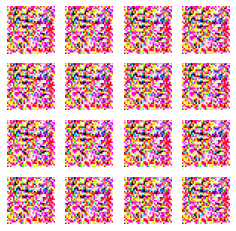

Training GAN at Time Step 1 of Epoch 27
Training GAN at Time Step 2 of Epoch 27
Training GAN at Time Step 3 of Epoch 27
Training GAN at Time Step 4 of Epoch 27
Training GAN at Time Step 5 of Epoch 27
Training GAN at Time Step 6 of Epoch 27
Training GAN at Time Step 7 of Epoch 27
Training GAN at Time Step 8 of Epoch 27
Training GAN at Time Step 9 of Epoch 27
Training GAN at Time Step 10 of Epoch 27
Training GAN at Time Step 11 of Epoch 27
Training GAN at Time Step 12 of Epoch 27
Training GAN at Time Step 13 of Epoch 27
Training GAN at Time Step 14 of Epoch 27
Training GAN at Time Step 15 of Epoch 27
Training GAN at Time Step 16 of Epoch 27
Training GAN at Time Step 17 of Epoch 27
Training GAN at Time Step 18 of Epoch 27
Training GAN at Time Step 19 of Epoch 27
Training GAN at Time Step 20 of Epoch 27
Training GAN at Time Step 21 of Epoch 27
Training GAN at Time Step 22 of Epoch 27
Training GAN at Time Step 23 of Epoch 27
Training GAN at Time Step 24 of Epoch 27
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 27


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

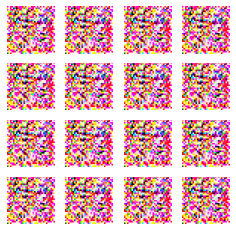

Training GAN at Time Step 1 of Epoch 28
Training GAN at Time Step 2 of Epoch 28
Training GAN at Time Step 3 of Epoch 28
Training GAN at Time Step 4 of Epoch 28
Training GAN at Time Step 5 of Epoch 28
Training GAN at Time Step 6 of Epoch 28
Training GAN at Time Step 7 of Epoch 28
Training GAN at Time Step 8 of Epoch 28
Training GAN at Time Step 9 of Epoch 28
Training GAN at Time Step 10 of Epoch 28
Training GAN at Time Step 11 of Epoch 28
Training GAN at Time Step 12 of Epoch 28
Training GAN at Time Step 13 of Epoch 28
Training GAN at Time Step 14 of Epoch 28
Training GAN at Time Step 15 of Epoch 28
Training GAN at Time Step 16 of Epoch 28
Training GAN at Time Step 17 of Epoch 28
Training GAN at Time Step 18 of Epoch 28
Training GAN at Time Step 19 of Epoch 28
Training GAN at Time Step 20 of Epoch 28
Training GAN at Time Step 21 of Epoch 28
Training GAN at Time Step 22 of Epoch 28
Training GAN at Time Step 23 of Epoch 28
Training GAN at Time Step 24 of Epoch 28
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

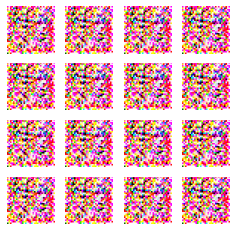

Training GAN at Time Step 1 of Epoch 29
Training GAN at Time Step 2 of Epoch 29
Training GAN at Time Step 3 of Epoch 29
Training GAN at Time Step 4 of Epoch 29
Training GAN at Time Step 5 of Epoch 29
Training GAN at Time Step 6 of Epoch 29
Training GAN at Time Step 7 of Epoch 29
Training GAN at Time Step 8 of Epoch 29
Training GAN at Time Step 9 of Epoch 29
Training GAN at Time Step 10 of Epoch 29
Training GAN at Time Step 11 of Epoch 29
Training GAN at Time Step 12 of Epoch 29
Training GAN at Time Step 13 of Epoch 29
Training GAN at Time Step 14 of Epoch 29
Training GAN at Time Step 15 of Epoch 29
Training GAN at Time Step 16 of Epoch 29
Training GAN at Time Step 17 of Epoch 29
Training GAN at Time Step 18 of Epoch 29
Training GAN at Time Step 19 of Epoch 29
Training GAN at Time Step 20 of Epoch 29
Training GAN at Time Step 21 of Epoch 29
Training GAN at Time Step 22 of Epoch 29
Training GAN at Time Step 23 of Epoch 29
Training GAN at Time Step 24 of Epoch 29
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

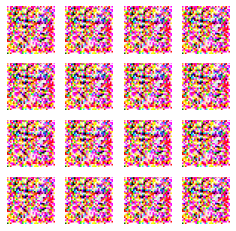

Training GAN at Time Step 1 of Epoch 30
Training GAN at Time Step 2 of Epoch 30
Training GAN at Time Step 3 of Epoch 30
Training GAN at Time Step 4 of Epoch 30
Training GAN at Time Step 5 of Epoch 30
Training GAN at Time Step 6 of Epoch 30
Training GAN at Time Step 7 of Epoch 30
Training GAN at Time Step 8 of Epoch 30
Training GAN at Time Step 9 of Epoch 30
Training GAN at Time Step 10 of Epoch 30
Training GAN at Time Step 11 of Epoch 30
Training GAN at Time Step 12 of Epoch 30
Training GAN at Time Step 13 of Epoch 30
Training GAN at Time Step 14 of Epoch 30
Training GAN at Time Step 15 of Epoch 30
Training GAN at Time Step 16 of Epoch 30
Training GAN at Time Step 17 of Epoch 30
Training GAN at Time Step 18 of Epoch 30
Training GAN at Time Step 19 of Epoch 30
Training GAN at Time Step 20 of Epoch 30
Training GAN at Time Step 21 of Epoch 30
Training GAN at Time Step 22 of Epoch 30
Training GAN at Time Step 23 of Epoch 30
Training GAN at Time Step 24 of Epoch 30
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

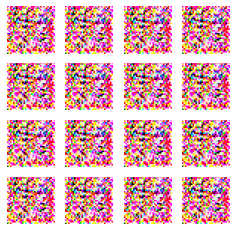

Training GAN at Time Step 1 of Epoch 31
Training GAN at Time Step 2 of Epoch 31
Training GAN at Time Step 3 of Epoch 31
Training GAN at Time Step 4 of Epoch 31
Training GAN at Time Step 5 of Epoch 31
Training GAN at Time Step 6 of Epoch 31
Training GAN at Time Step 7 of Epoch 31
Training GAN at Time Step 8 of Epoch 31
Training GAN at Time Step 9 of Epoch 31
Training GAN at Time Step 10 of Epoch 31
Training GAN at Time Step 11 of Epoch 31
Training GAN at Time Step 12 of Epoch 31
Training GAN at Time Step 13 of Epoch 31
Training GAN at Time Step 14 of Epoch 31
Training GAN at Time Step 15 of Epoch 31
Training GAN at Time Step 16 of Epoch 31
Training GAN at Time Step 17 of Epoch 31
Training GAN at Time Step 18 of Epoch 31
Training GAN at Time Step 19 of Epoch 31
Training GAN at Time Step 20 of Epoch 31
Training GAN at Time Step 21 of Epoch 31
Training GAN at Time Step 22 of Epoch 31
Training GAN at Time Step 23 of Epoch 31
Training GAN at Time Step 24 of Epoch 31
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 31


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

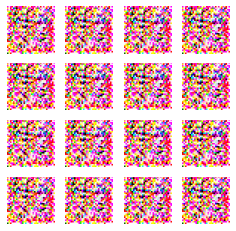

Training GAN at Time Step 1 of Epoch 32
Training GAN at Time Step 2 of Epoch 32
Training GAN at Time Step 3 of Epoch 32
Training GAN at Time Step 4 of Epoch 32
Training GAN at Time Step 5 of Epoch 32
Training GAN at Time Step 6 of Epoch 32
Training GAN at Time Step 7 of Epoch 32
Training GAN at Time Step 8 of Epoch 32
Training GAN at Time Step 9 of Epoch 32
Training GAN at Time Step 10 of Epoch 32
Training GAN at Time Step 11 of Epoch 32
Training GAN at Time Step 12 of Epoch 32
Training GAN at Time Step 13 of Epoch 32
Training GAN at Time Step 14 of Epoch 32
Training GAN at Time Step 15 of Epoch 32
Training GAN at Time Step 16 of Epoch 32
Training GAN at Time Step 17 of Epoch 32
Training GAN at Time Step 18 of Epoch 32
Training GAN at Time Step 19 of Epoch 32
Training GAN at Time Step 20 of Epoch 32
Training GAN at Time Step 21 of Epoch 32
Training GAN at Time Step 22 of Epoch 32
Training GAN at Time Step 23 of Epoch 32
Training GAN at Time Step 24 of Epoch 32
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

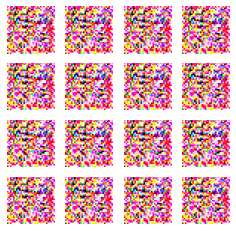

Training GAN at Time Step 1 of Epoch 33
Training GAN at Time Step 2 of Epoch 33
Training GAN at Time Step 3 of Epoch 33
Training GAN at Time Step 4 of Epoch 33
Training GAN at Time Step 5 of Epoch 33
Training GAN at Time Step 6 of Epoch 33
Training GAN at Time Step 7 of Epoch 33
Training GAN at Time Step 8 of Epoch 33
Training GAN at Time Step 9 of Epoch 33
Training GAN at Time Step 10 of Epoch 33
Training GAN at Time Step 11 of Epoch 33
Training GAN at Time Step 12 of Epoch 33
Training GAN at Time Step 13 of Epoch 33
Training GAN at Time Step 14 of Epoch 33
Training GAN at Time Step 15 of Epoch 33
Training GAN at Time Step 16 of Epoch 33
Training GAN at Time Step 17 of Epoch 33
Training GAN at Time Step 18 of Epoch 33
Training GAN at Time Step 19 of Epoch 33
Training GAN at Time Step 20 of Epoch 33
Training GAN at Time Step 21 of Epoch 33
Training GAN at Time Step 22 of Epoch 33
Training GAN at Time Step 23 of Epoch 33
Training GAN at Time Step 24 of Epoch 33
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 33


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

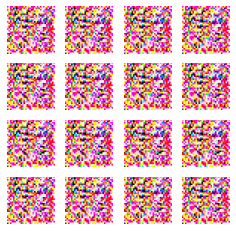

Training GAN at Time Step 1 of Epoch 34
Training GAN at Time Step 2 of Epoch 34
Training GAN at Time Step 3 of Epoch 34
Training GAN at Time Step 4 of Epoch 34
Training GAN at Time Step 5 of Epoch 34
Training GAN at Time Step 6 of Epoch 34
Training GAN at Time Step 7 of Epoch 34
Training GAN at Time Step 8 of Epoch 34
Training GAN at Time Step 9 of Epoch 34
Training GAN at Time Step 10 of Epoch 34
Training GAN at Time Step 11 of Epoch 34
Training GAN at Time Step 12 of Epoch 34
Training GAN at Time Step 13 of Epoch 34
Training GAN at Time Step 14 of Epoch 34
Training GAN at Time Step 15 of Epoch 34
Training GAN at Time Step 16 of Epoch 34
Training GAN at Time Step 17 of Epoch 34
Training GAN at Time Step 18 of Epoch 34
Training GAN at Time Step 19 of Epoch 34
Training GAN at Time Step 20 of Epoch 34
Training GAN at Time Step 21 of Epoch 34
Training GAN at Time Step 22 of Epoch 34
Training GAN at Time Step 23 of Epoch 34
Training GAN at Time Step 24 of Epoch 34
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 34


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

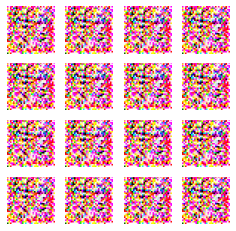

Training GAN at Time Step 1 of Epoch 35
Training GAN at Time Step 2 of Epoch 35
Training GAN at Time Step 3 of Epoch 35
Training GAN at Time Step 4 of Epoch 35
Training GAN at Time Step 5 of Epoch 35
Training GAN at Time Step 6 of Epoch 35
Training GAN at Time Step 7 of Epoch 35
Training GAN at Time Step 8 of Epoch 35
Training GAN at Time Step 9 of Epoch 35
Training GAN at Time Step 10 of Epoch 35
Training GAN at Time Step 11 of Epoch 35
Training GAN at Time Step 12 of Epoch 35
Training GAN at Time Step 13 of Epoch 35
Training GAN at Time Step 14 of Epoch 35
Training GAN at Time Step 15 of Epoch 35
Training GAN at Time Step 16 of Epoch 35
Training GAN at Time Step 17 of Epoch 35
Training GAN at Time Step 18 of Epoch 35
Training GAN at Time Step 19 of Epoch 35
Training GAN at Time Step 20 of Epoch 35
Training GAN at Time Step 21 of Epoch 35
Training GAN at Time Step 22 of Epoch 35
Training GAN at Time Step 23 of Epoch 35
Training GAN at Time Step 24 of Epoch 35
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

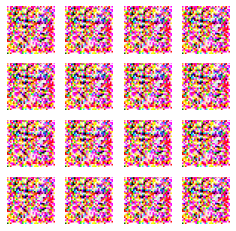

Training GAN at Time Step 1 of Epoch 36
Training GAN at Time Step 2 of Epoch 36
Training GAN at Time Step 3 of Epoch 36
Training GAN at Time Step 4 of Epoch 36
Training GAN at Time Step 5 of Epoch 36
Training GAN at Time Step 6 of Epoch 36
Training GAN at Time Step 7 of Epoch 36
Training GAN at Time Step 8 of Epoch 36
Training GAN at Time Step 9 of Epoch 36
Training GAN at Time Step 10 of Epoch 36
Training GAN at Time Step 11 of Epoch 36
Training GAN at Time Step 12 of Epoch 36
Training GAN at Time Step 13 of Epoch 36
Training GAN at Time Step 14 of Epoch 36
Training GAN at Time Step 15 of Epoch 36
Training GAN at Time Step 16 of Epoch 36
Training GAN at Time Step 17 of Epoch 36
Training GAN at Time Step 18 of Epoch 36
Training GAN at Time Step 19 of Epoch 36
Training GAN at Time Step 20 of Epoch 36
Training GAN at Time Step 21 of Epoch 36
Training GAN at Time Step 22 of Epoch 36
Training GAN at Time Step 23 of Epoch 36
Training GAN at Time Step 24 of Epoch 36
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

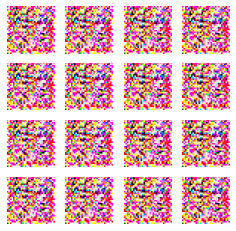

Training GAN at Time Step 1 of Epoch 37
Training GAN at Time Step 2 of Epoch 37
Training GAN at Time Step 3 of Epoch 37
Training GAN at Time Step 4 of Epoch 37
Training GAN at Time Step 5 of Epoch 37
Training GAN at Time Step 6 of Epoch 37
Training GAN at Time Step 7 of Epoch 37
Training GAN at Time Step 8 of Epoch 37
Training GAN at Time Step 9 of Epoch 37
Training GAN at Time Step 10 of Epoch 37
Training GAN at Time Step 11 of Epoch 37
Training GAN at Time Step 12 of Epoch 37
Training GAN at Time Step 13 of Epoch 37
Training GAN at Time Step 14 of Epoch 37
Training GAN at Time Step 15 of Epoch 37
Training GAN at Time Step 16 of Epoch 37
Training GAN at Time Step 17 of Epoch 37
Training GAN at Time Step 18 of Epoch 37
Training GAN at Time Step 19 of Epoch 37
Training GAN at Time Step 20 of Epoch 37
Training GAN at Time Step 21 of Epoch 37
Training GAN at Time Step 22 of Epoch 37
Training GAN at Time Step 23 of Epoch 37
Training GAN at Time Step 24 of Epoch 37
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 37


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

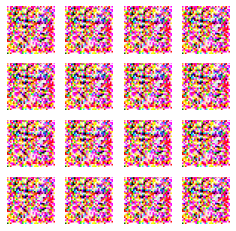

Training GAN at Time Step 1 of Epoch 38
Training GAN at Time Step 2 of Epoch 38
Training GAN at Time Step 3 of Epoch 38
Training GAN at Time Step 4 of Epoch 38
Training GAN at Time Step 5 of Epoch 38
Training GAN at Time Step 6 of Epoch 38
Training GAN at Time Step 7 of Epoch 38
Training GAN at Time Step 8 of Epoch 38
Training GAN at Time Step 9 of Epoch 38
Training GAN at Time Step 10 of Epoch 38
Training GAN at Time Step 11 of Epoch 38
Training GAN at Time Step 12 of Epoch 38
Training GAN at Time Step 13 of Epoch 38
Training GAN at Time Step 14 of Epoch 38
Training GAN at Time Step 15 of Epoch 38
Training GAN at Time Step 16 of Epoch 38
Training GAN at Time Step 17 of Epoch 38
Training GAN at Time Step 18 of Epoch 38
Training GAN at Time Step 19 of Epoch 38
Training GAN at Time Step 20 of Epoch 38
Training GAN at Time Step 21 of Epoch 38
Training GAN at Time Step 22 of Epoch 38
Training GAN at Time Step 23 of Epoch 38
Training GAN at Time Step 24 of Epoch 38
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

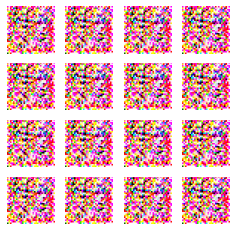

Training GAN at Time Step 1 of Epoch 39
Training GAN at Time Step 2 of Epoch 39
Training GAN at Time Step 3 of Epoch 39
Training GAN at Time Step 4 of Epoch 39
Training GAN at Time Step 5 of Epoch 39
Training GAN at Time Step 6 of Epoch 39
Training GAN at Time Step 7 of Epoch 39
Training GAN at Time Step 8 of Epoch 39
Training GAN at Time Step 9 of Epoch 39
Training GAN at Time Step 10 of Epoch 39
Training GAN at Time Step 11 of Epoch 39
Training GAN at Time Step 12 of Epoch 39
Training GAN at Time Step 13 of Epoch 39
Training GAN at Time Step 14 of Epoch 39
Training GAN at Time Step 15 of Epoch 39
Training GAN at Time Step 16 of Epoch 39
Training GAN at Time Step 17 of Epoch 39
Training GAN at Time Step 18 of Epoch 39
Training GAN at Time Step 19 of Epoch 39
Training GAN at Time Step 20 of Epoch 39
Training GAN at Time Step 21 of Epoch 39
Training GAN at Time Step 22 of Epoch 39
Training GAN at Time Step 23 of Epoch 39
Training GAN at Time Step 24 of Epoch 39
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

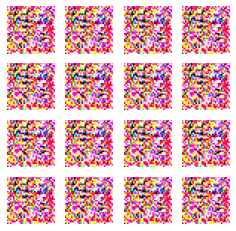

Training GAN at Time Step 1 of Epoch 40
Training GAN at Time Step 2 of Epoch 40
Training GAN at Time Step 3 of Epoch 40
Training GAN at Time Step 4 of Epoch 40
Training GAN at Time Step 5 of Epoch 40
Training GAN at Time Step 6 of Epoch 40
Training GAN at Time Step 7 of Epoch 40
Training GAN at Time Step 8 of Epoch 40
Training GAN at Time Step 9 of Epoch 40
Training GAN at Time Step 10 of Epoch 40
Training GAN at Time Step 11 of Epoch 40
Training GAN at Time Step 12 of Epoch 40
Training GAN at Time Step 13 of Epoch 40
Training GAN at Time Step 14 of Epoch 40
Training GAN at Time Step 15 of Epoch 40
Training GAN at Time Step 16 of Epoch 40
Training GAN at Time Step 17 of Epoch 40
Training GAN at Time Step 18 of Epoch 40
Training GAN at Time Step 19 of Epoch 40
Training GAN at Time Step 20 of Epoch 40
Training GAN at Time Step 21 of Epoch 40
Training GAN at Time Step 22 of Epoch 40
Training GAN at Time Step 23 of Epoch 40
Training GAN at Time Step 24 of Epoch 40
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

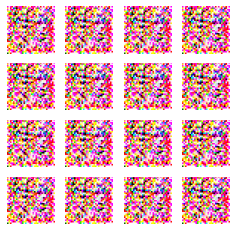

Training GAN at Time Step 1 of Epoch 41
Training GAN at Time Step 2 of Epoch 41
Training GAN at Time Step 3 of Epoch 41
Training GAN at Time Step 4 of Epoch 41
Training GAN at Time Step 5 of Epoch 41
Training GAN at Time Step 6 of Epoch 41
Training GAN at Time Step 7 of Epoch 41
Training GAN at Time Step 8 of Epoch 41
Training GAN at Time Step 9 of Epoch 41
Training GAN at Time Step 10 of Epoch 41
Training GAN at Time Step 11 of Epoch 41
Training GAN at Time Step 12 of Epoch 41
Training GAN at Time Step 13 of Epoch 41
Training GAN at Time Step 14 of Epoch 41
Training GAN at Time Step 15 of Epoch 41
Training GAN at Time Step 16 of Epoch 41
Training GAN at Time Step 17 of Epoch 41
Training GAN at Time Step 18 of Epoch 41
Training GAN at Time Step 19 of Epoch 41
Training GAN at Time Step 20 of Epoch 41
Training GAN at Time Step 21 of Epoch 41
Training GAN at Time Step 22 of Epoch 41
Training GAN at Time Step 23 of Epoch 41
Training GAN at Time Step 24 of Epoch 41
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

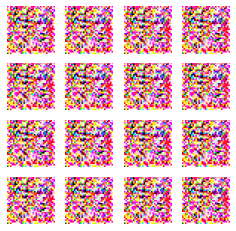

Training GAN at Time Step 1 of Epoch 42
Training GAN at Time Step 2 of Epoch 42
Training GAN at Time Step 3 of Epoch 42
Training GAN at Time Step 4 of Epoch 42
Training GAN at Time Step 5 of Epoch 42
Training GAN at Time Step 6 of Epoch 42
Training GAN at Time Step 7 of Epoch 42
Training GAN at Time Step 8 of Epoch 42
Training GAN at Time Step 9 of Epoch 42
Training GAN at Time Step 10 of Epoch 42
Training GAN at Time Step 11 of Epoch 42
Training GAN at Time Step 12 of Epoch 42
Training GAN at Time Step 13 of Epoch 42
Training GAN at Time Step 14 of Epoch 42
Training GAN at Time Step 15 of Epoch 42
Training GAN at Time Step 16 of Epoch 42
Training GAN at Time Step 17 of Epoch 42
Training GAN at Time Step 18 of Epoch 42
Training GAN at Time Step 19 of Epoch 42
Training GAN at Time Step 20 of Epoch 42
Training GAN at Time Step 21 of Epoch 42
Training GAN at Time Step 22 of Epoch 42
Training GAN at Time Step 23 of Epoch 42
Training GAN at Time Step 24 of Epoch 42
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 42


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

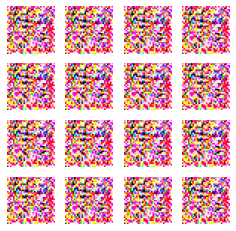

Training GAN at Time Step 1 of Epoch 43
Training GAN at Time Step 2 of Epoch 43
Training GAN at Time Step 3 of Epoch 43
Training GAN at Time Step 4 of Epoch 43
Training GAN at Time Step 5 of Epoch 43
Training GAN at Time Step 6 of Epoch 43
Training GAN at Time Step 7 of Epoch 43
Training GAN at Time Step 8 of Epoch 43
Training GAN at Time Step 9 of Epoch 43
Training GAN at Time Step 10 of Epoch 43
Training GAN at Time Step 11 of Epoch 43
Training GAN at Time Step 12 of Epoch 43
Training GAN at Time Step 13 of Epoch 43
Training GAN at Time Step 14 of Epoch 43
Training GAN at Time Step 15 of Epoch 43
Training GAN at Time Step 16 of Epoch 43
Training GAN at Time Step 17 of Epoch 43
Training GAN at Time Step 18 of Epoch 43
Training GAN at Time Step 19 of Epoch 43
Training GAN at Time Step 20 of Epoch 43
Training GAN at Time Step 21 of Epoch 43
Training GAN at Time Step 22 of Epoch 43
Training GAN at Time Step 23 of Epoch 43
Training GAN at Time Step 24 of Epoch 43
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 43


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

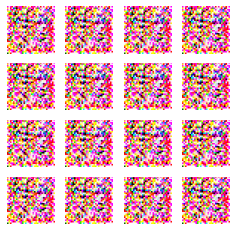

Training GAN at Time Step 1 of Epoch 44
Training GAN at Time Step 2 of Epoch 44
Training GAN at Time Step 3 of Epoch 44
Training GAN at Time Step 4 of Epoch 44
Training GAN at Time Step 5 of Epoch 44
Training GAN at Time Step 6 of Epoch 44
Training GAN at Time Step 7 of Epoch 44
Training GAN at Time Step 8 of Epoch 44
Training GAN at Time Step 9 of Epoch 44
Training GAN at Time Step 10 of Epoch 44
Training GAN at Time Step 11 of Epoch 44
Training GAN at Time Step 12 of Epoch 44
Training GAN at Time Step 13 of Epoch 44
Training GAN at Time Step 14 of Epoch 44
Training GAN at Time Step 15 of Epoch 44
Training GAN at Time Step 16 of Epoch 44
Training GAN at Time Step 17 of Epoch 44
Training GAN at Time Step 18 of Epoch 44
Training GAN at Time Step 19 of Epoch 44
Training GAN at Time Step 20 of Epoch 44
Training GAN at Time Step 21 of Epoch 44
Training GAN at Time Step 22 of Epoch 44
Training GAN at Time Step 23 of Epoch 44
Training GAN at Time Step 24 of Epoch 44
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

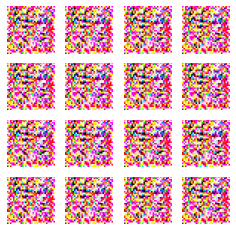

Training GAN at Time Step 1 of Epoch 45
Training GAN at Time Step 2 of Epoch 45
Training GAN at Time Step 3 of Epoch 45
Training GAN at Time Step 4 of Epoch 45
Training GAN at Time Step 5 of Epoch 45
Training GAN at Time Step 6 of Epoch 45
Training GAN at Time Step 7 of Epoch 45
Training GAN at Time Step 8 of Epoch 45
Training GAN at Time Step 9 of Epoch 45
Training GAN at Time Step 10 of Epoch 45
Training GAN at Time Step 11 of Epoch 45
Training GAN at Time Step 12 of Epoch 45
Training GAN at Time Step 13 of Epoch 45
Training GAN at Time Step 14 of Epoch 45
Training GAN at Time Step 15 of Epoch 45
Training GAN at Time Step 16 of Epoch 45
Training GAN at Time Step 17 of Epoch 45
Training GAN at Time Step 18 of Epoch 45
Training GAN at Time Step 19 of Epoch 45
Training GAN at Time Step 20 of Epoch 45
Training GAN at Time Step 21 of Epoch 45
Training GAN at Time Step 22 of Epoch 45
Training GAN at Time Step 23 of Epoch 45
Training GAN at Time Step 24 of Epoch 45
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 45


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

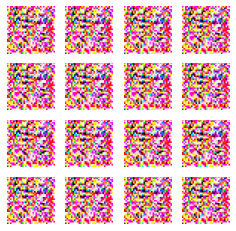

Training GAN at Time Step 1 of Epoch 46
Training GAN at Time Step 2 of Epoch 46
Training GAN at Time Step 3 of Epoch 46
Training GAN at Time Step 4 of Epoch 46
Training GAN at Time Step 5 of Epoch 46
Training GAN at Time Step 6 of Epoch 46
Training GAN at Time Step 7 of Epoch 46
Training GAN at Time Step 8 of Epoch 46
Training GAN at Time Step 9 of Epoch 46
Training GAN at Time Step 10 of Epoch 46
Training GAN at Time Step 11 of Epoch 46
Training GAN at Time Step 12 of Epoch 46
Training GAN at Time Step 13 of Epoch 46
Training GAN at Time Step 14 of Epoch 46
Training GAN at Time Step 15 of Epoch 46
Training GAN at Time Step 16 of Epoch 46
Training GAN at Time Step 17 of Epoch 46
Training GAN at Time Step 18 of Epoch 46
Training GAN at Time Step 19 of Epoch 46
Training GAN at Time Step 20 of Epoch 46
Training GAN at Time Step 21 of Epoch 46
Training GAN at Time Step 22 of Epoch 46
Training GAN at Time Step 23 of Epoch 46
Training GAN at Time Step 24 of Epoch 46
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 46


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

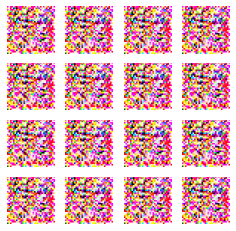

Training GAN at Time Step 1 of Epoch 47
Training GAN at Time Step 2 of Epoch 47
Training GAN at Time Step 3 of Epoch 47
Training GAN at Time Step 4 of Epoch 47
Training GAN at Time Step 5 of Epoch 47
Training GAN at Time Step 6 of Epoch 47
Training GAN at Time Step 7 of Epoch 47
Training GAN at Time Step 8 of Epoch 47
Training GAN at Time Step 9 of Epoch 47
Training GAN at Time Step 10 of Epoch 47
Training GAN at Time Step 11 of Epoch 47
Training GAN at Time Step 12 of Epoch 47
Training GAN at Time Step 13 of Epoch 47
Training GAN at Time Step 14 of Epoch 47
Training GAN at Time Step 15 of Epoch 47
Training GAN at Time Step 16 of Epoch 47
Training GAN at Time Step 17 of Epoch 47
Training GAN at Time Step 18 of Epoch 47
Training GAN at Time Step 19 of Epoch 47
Training GAN at Time Step 20 of Epoch 47
Training GAN at Time Step 21 of Epoch 47
Training GAN at Time Step 22 of Epoch 47
Training GAN at Time Step 23 of Epoch 47
Training GAN at Time Step 24 of Epoch 47
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 47


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

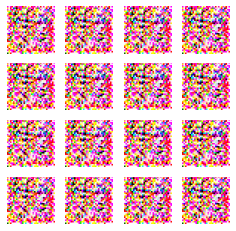

Training GAN at Time Step 1 of Epoch 48
Training GAN at Time Step 2 of Epoch 48
Training GAN at Time Step 3 of Epoch 48
Training GAN at Time Step 4 of Epoch 48
Training GAN at Time Step 5 of Epoch 48
Training GAN at Time Step 6 of Epoch 48
Training GAN at Time Step 7 of Epoch 48
Training GAN at Time Step 8 of Epoch 48
Training GAN at Time Step 9 of Epoch 48
Training GAN at Time Step 10 of Epoch 48
Training GAN at Time Step 11 of Epoch 48
Training GAN at Time Step 12 of Epoch 48
Training GAN at Time Step 13 of Epoch 48
Training GAN at Time Step 14 of Epoch 48
Training GAN at Time Step 15 of Epoch 48
Training GAN at Time Step 16 of Epoch 48
Training GAN at Time Step 17 of Epoch 48
Training GAN at Time Step 18 of Epoch 48
Training GAN at Time Step 19 of Epoch 48
Training GAN at Time Step 20 of Epoch 48
Training GAN at Time Step 21 of Epoch 48
Training GAN at Time Step 22 of Epoch 48
Training GAN at Time Step 23 of Epoch 48
Training GAN at Time Step 24 of Epoch 48
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 48


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

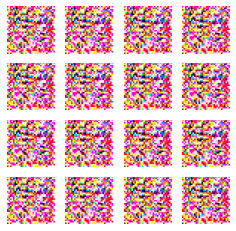

Training GAN at Time Step 1 of Epoch 49
Training GAN at Time Step 2 of Epoch 49
Training GAN at Time Step 3 of Epoch 49
Training GAN at Time Step 4 of Epoch 49
Training GAN at Time Step 5 of Epoch 49
Training GAN at Time Step 6 of Epoch 49
Training GAN at Time Step 7 of Epoch 49
Training GAN at Time Step 8 of Epoch 49
Training GAN at Time Step 9 of Epoch 49
Training GAN at Time Step 10 of Epoch 49
Training GAN at Time Step 11 of Epoch 49
Training GAN at Time Step 12 of Epoch 49
Training GAN at Time Step 13 of Epoch 49
Training GAN at Time Step 14 of Epoch 49
Training GAN at Time Step 15 of Epoch 49
Training GAN at Time Step 16 of Epoch 49
Training GAN at Time Step 17 of Epoch 49
Training GAN at Time Step 18 of Epoch 49
Training GAN at Time Step 19 of Epoch 49
Training GAN at Time Step 20 of Epoch 49
Training GAN at Time Step 21 of Epoch 49
Training GAN at Time Step 22 of Epoch 49
Training GAN at Time Step 23 of Epoch 49
Training GAN at Time Step 24 of Epoch 49
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 49


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

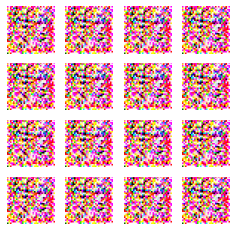

Training GAN at Time Step 1 of Epoch 50
Training GAN at Time Step 2 of Epoch 50
Training GAN at Time Step 3 of Epoch 50
Training GAN at Time Step 4 of Epoch 50
Training GAN at Time Step 5 of Epoch 50
Training GAN at Time Step 6 of Epoch 50
Training GAN at Time Step 7 of Epoch 50
Training GAN at Time Step 8 of Epoch 50
Training GAN at Time Step 9 of Epoch 50
Training GAN at Time Step 10 of Epoch 50
Training GAN at Time Step 11 of Epoch 50
Training GAN at Time Step 12 of Epoch 50
Training GAN at Time Step 13 of Epoch 50
Training GAN at Time Step 14 of Epoch 50
Training GAN at Time Step 15 of Epoch 50
Training GAN at Time Step 16 of Epoch 50
Training GAN at Time Step 17 of Epoch 50
Training GAN at Time Step 18 of Epoch 50
Training GAN at Time Step 19 of Epoch 50
Training GAN at Time Step 20 of Epoch 50
Training GAN at Time Step 21 of Epoch 50
Training GAN at Time Step 22 of Epoch 50
Training GAN at Time Step 23 of Epoch 50
Training GAN at Time Step 24 of Epoch 50
Training GAN at Time Step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training GAN at Time Step 28 of Epoch 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

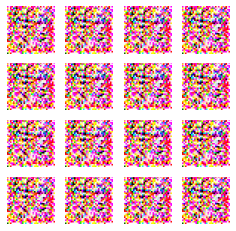

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

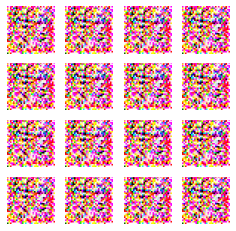

In [104]:
train_gan(real_imgs_datagen=unlabeled_datagen,total_epochs=GAN_epochs)

In [105]:
latest_checkpoint_path = tf.train.latest_checkpoint("/content/drive/MyDrive/GAN_training_checkpoints")

In [106]:
latest_checkpoint_path

'/content/drive/MyDrive/GAN_training_checkpoints/ckpt-10'

In [107]:
GAN_checkpoint.restore(latest_checkpoint_path)

In [108]:
def generate_and_save_images(generator_model,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

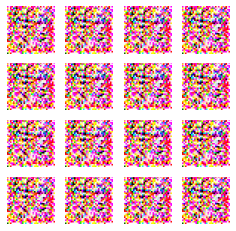

In [109]:
generate_and_save_images(generator_model=G,test_input=constant_noise)

In [110]:
unlbled_imgs_base_path = "/content/drive/MyDrive/MelanomaDetection/MelanomaDetection/unlabeled"

In [111]:
from random import randint

In [112]:
imgs_name_list = os.listdir(unlbled_imgs_base_path)

In [113]:
total_imgs= len(imgs_name_list)

In [114]:
single_imgs = plt.imread(os.path.join(unlbled_imgs_base_path,imgs_name_list[randint(0,total_imgs-1)]))

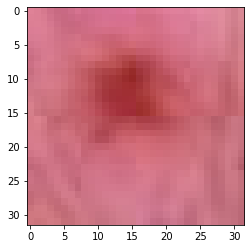

In [115]:
plt.imshow(single_imgs)

In [116]:
single_fake_img = G(tf.random.normal(shape=(1,100)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


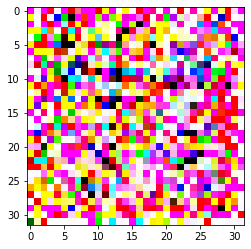

In [118]:
plt.imshow(single_fake_img[0,:,:,:])

In [119]:
def discriminator_base():

  input_to_cls = Input(shape=(32,32,3))

  disc_base = Sequential(name="disc_base")
  disc_base.add(input_to_cls)

  for layer in D.layers[0:10]:
    disc_base.add(layer)

  return disc_base

In [120]:
def unsupervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [121]:
def supervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [122]:
unsupervised_cls = unsupervised_classifier()
supervised_cls = supervised_classifier()

In [123]:
unsupervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)
supervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.3)

In [124]:
supervised_cls_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_cv_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [125]:
def unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = tf.ones_like(real_imgs_preds)
  fake_imgs_labels = tf.zeros_like(fake_imgs_preds)

  real_imgs_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_loss + fake_imgs_loss

  return total_loss

In [126]:
def supervised_cls_loss(imgs_labels,imgs_preds):

  return bce_loss(y_true=imgs_labels,y_pred=imgs_labels)